In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install -q -U watermark

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
torchvision 0.6.1+cu101


In [6]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# To filter/truncate warnings
import warnings
warnings.filterwarnings('ignore')

Unzipping train and test

In [8]:
%cd drive/My\ Drive/
!ls

/content/drive/My Drive
'Colab Notebooks'   data


In [9]:
%cd data/
!ls

/content/drive/My Drive/data
apparelsdata	      test.csv		    train
best_model_state.bin  test_predictions.csv  train.csv
test		      test_ScVgIM0.zip	    train_LbELtWX.zip


In [9]:
!unzip -qq train_LbELtWX.zip
!unzip -qq test_ScVgIM0.zip

error:  cannot create train/3751.png
        Input/output error
replace train/46774.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
no_of_train_images = glob('train/*')
no_of_test_images = glob('test/*')

print("We have {} images in train and {} images in test".format(len(no_of_train_images),len(no_of_test_images)))

We have 60000 images in train and 10000 images in test


In [11]:
traindata=pd.read_csv('train.csv')
testdata=pd.read_csv('test.csv')

In [12]:
print(traindata.shape);print(testdata.shape)

(60000, 2)
(10000, 1)


In [13]:
print(traindata.columns);print(testdata.columns)

Index(['id', 'label'], dtype='object')
Index(['id'], dtype='object')


In [14]:
traindata.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [15]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot']
class_indices = list(range(10))

In [16]:
DATA_DIR = Path('apparelsdata')
DATASETS = ['train', 'val']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [17]:
!ls apparelsdata/train/

Ankle-boot  Coat   Pullover  Shirt    Trouser
Bag	    Dress  Sandal    Sneaker  T-shirt


In [18]:
!ls apparelsdata/val/

Ankle-boot  Coat   Pullover  Shirt    Trouser
Bag	    Dress  Sandal    Sneaker  T-shirt


In [19]:
Tshirtimages = []
Trouserimages = []
Pulloverimages = []
Dressimages = []
Coatimages = []
Sandalimages = []
Shirtimages = []
Sneakerimages = []
Bagimages = []
Anklebootimages = []

for image_id,label in zip(traindata.iloc[:, 0], traindata.iloc[:, 1]):

  if label == 0:
    Tshirtimages.extend(glob(f'train/{image_id}.png'))
  elif label == 1:
    Trouserimages.extend(glob(f'train/{image_id}.png'))
  elif label == 2:
    Pulloverimages.extend(glob(f'train/{image_id}.png'))
  elif label == 3:
    Dressimages.extend(glob(f'train/{image_id}.png'))
  elif label == 4:
    Coatimages.extend(glob(f'train/{image_id}.png'))
  elif label == 5:
    Sandalimages.extend(glob(f'train/{image_id}.png'))
  elif label == 6:
    Shirtimages.extend(glob(f'train/{image_id}.png'))
  elif label == 7:
    Sneakerimages.extend(glob(f'train/{image_id}.png'))
  elif label == 8:
    Bagimages.extend(glob(f'train/{image_id}.png'))
  else:
    Anklebootimages.extend(glob(f'train/{image_id}.png'))

In [20]:
print("There are {} images in T-shirt class".format(len(Tshirtimages)))
print("There are {} images in Trouser class".format(len(Trouserimages)))
print("There are {} images in Pullover class".format(len(Pulloverimages)))
print("There are {} images in Dress class".format(len(Dressimages)))
print("There are {} images in Coat class".format(len(Coatimages)))
print("There are {} images in Sandal class".format(len(Sandalimages)))
print("There are {} images in Shirt class".format(len(Shirtimages)))
print("There are {} images in Sneaker class".format(len(Sneakerimages)))
print("There are {} images in Bag class".format(len(Bagimages)))
print("There are {} images in Ankle-boot class".format(len(Anklebootimages)))

There are 6000 images in T-shirt class
There are 6000 images in Trouser class
There are 6000 images in Pullover class
There are 6000 images in Dress class
There are 6000 images in Coat class
There are 6000 images in Sandal class
There are 6000 images in Shirt class
There are 6000 images in Sneaker class
There are 6000 images in Bag class
There are 6000 images in Ankle-boot class


This is a completely class balanced data!

**Building a dataset**

In [14]:
image_paths=[Tshirtimages, Trouserimages, Pulloverimages, Dressimages, Coatimages, Sandalimages, Shirtimages, Sneakerimages, Bagimages, Anklebootimages]

In [19]:
def load_images_to_path(image_path,class_name):

  #images = np.array([load_image(img) for img in image_path])
  images = np.array(image_path)
  np.random.shuffle(images)
  print(images.shape)

  ds_split = np.split(
                      images, 
                      indices_or_sections=[int(.9*len(images))]
                      )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img in images:
      shutil.copy(img, f'{DATA_DIR}/{ds}/{class_name}/')
    print("{} Images loaded to the path {}/{}/{}".format(len(glob(f'{DATA_DIR}/{ds}/{class_name}/*.png')),DATA_DIR,ds,class_name))

In [27]:
for i, image_path in enumerate(image_paths):
  print (i)
  print (class_names[i])
  print (image_path)
  load_images_to_path(image_path, class_names[i])

0
T-shirt
['train/2.png', 'train/3.png', 'train/5.png', 'train/11.png', 'train/18.png', 'train/27.png', 'train/35.png', 'train/49.png', 'train/62.png', 'train/65.png', 'train/67.png', 'train/68.png', 'train/102.png', 'train/150.png', 'train/155.png', 'train/161.png', 'train/170.png', 'train/172.png', 'train/177.png', 'train/181.png', 'train/183.png', 'train/187.png', 'train/188.png', 'train/192.png', 'train/203.png', 'train/208.png', 'train/220.png', 'train/223.png', 'train/226.png', 'train/238.png', 'train/270.png', 'train/273.png', 'train/303.png', 'train/305.png', 'train/322.png', 'train/326.png', 'train/330.png', 'train/332.png', 'train/339.png', 'train/355.png', 'train/378.png', 'train/384.png', 'train/393.png', 'train/416.png', 'train/430.png', 'train/439.png', 'train/442.png', 'train/445.png', 'train/446.png', 'train/449.png', 'train/490.png', 'train/494.png', 'train/505.png', 'train/517.png', 'train/520.png', 'train/523.png', 'train/525.png', 'train/531.png', 'train/565.png', '

In [18]:
for class_name in class_names:
  for ds in DATASETS:
    print ("***", class_name,":",ds,"***")
    print(len(glob(f'{DATA_DIR}/{ds}/{class_name}/*.png')))

*** T-shirt : train ***
5400
*** T-shirt : val ***
600
*** Trouser : train ***
5400
*** Trouser : val ***
600
*** Pullover : train ***
5400
*** Pullover : val ***
600
*** Dress : train ***
5400
*** Dress : val ***
600
*** Coat : train ***
5400
*** Coat : val ***
600
*** Sandal : train ***
5400
*** Sandal : val ***
600
*** Shirt : train ***
5400
*** Shirt : val ***
600
*** Sneaker : train ***
5400
*** Sneaker : val ***
600
*** Bag : train ***
5400
*** Bag : val ***
600
*** Ankle-boot : train ***
5400
*** Ankle-boot : val ***
600


In [88]:
(DATA_DIR / 'test' / 'Unknown').mkdir(parents=True, exist_ok=True)
for img_path in glob('test/*.png'):
  shutil.copy(img_path, f'{DATA_DIR}/test/Unknown/')
print ("{} Images moved to {}/{}/{}".format(len(glob(f'{DATA_DIR}/test/Unknown/*.png')),DATA_DIR,'test','Unknown'))

10000 Images moved to apparelsdata/test/Unknown


In [20]:
def load_image(img_path):
  img = cv2.imread(img_path)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths,title=None):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  if title is not None:
    plt.title(title)
  plt.axis('off');

Let's have a look at some examples for each fashion apparel:

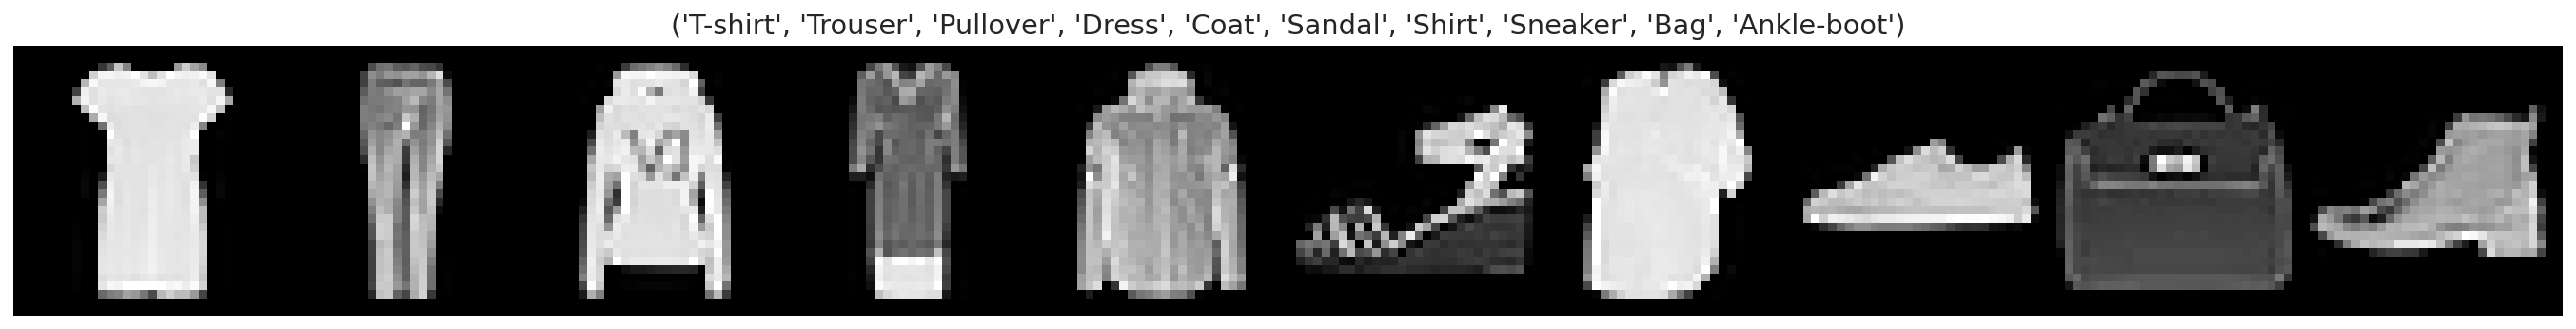

In [11]:
train_folders=glob('apparelsdata/train/*')
class_names = [(tf.split('/')[2]) for tf in train_folders]
sample_images = [np.random.choice(glob(f'{tf}/*.png')) for tf in train_folders]
image, class_name = zip(*zip(sample_images, class_names))
show_sign_grid(image, class_name)

* We'll be doing a little data augmentation, trying to improve the performance of our model by forcing it to learn about images at different angles and crops.
* Next, we'll make tensors out of the images, as PyTorch works with tensors.
* Finally, we'll normalize the images, which helps the network work with values that may be have a wide range of different values.
* We then compose all our chosen transforms. 

Note that the validation transforms don't have any of the flipping or rotating, as they aren't part of our training set, so the network isn't learning about them







In [21]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Now we will use PyTorch's ImageFolder function to create datasets:

In [22]:
from PIL import Image, ImageOps

def gray_reader(image_path):
    im1 = Image.open(image_path)
    im2 = ImageOps.grayscale(im1)
    im1.close()
    return im2

In [23]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
  #d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d], loader=gray_reader) for d in DATASETS
}

Now that we have chosen the image folders we want, we need to use the DataLoaders to create iterable objects for us to work with. We tell it which datasets we want to use, give it a batch size, and shuffle the data.

In [24]:
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=4) 
  for d in DATASETS
}

We're going to need to preserve some information about our dataset, specifically the size of the dataset and the names of the classes in our dataset.

In [25]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

print("dataset sizes are",dataset_sizes)
print("available classes are",class_names)

dataset sizes are {'train': 54000, 'val': 6000}
available classes are ['Ankle-boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


let's verify the shape of each iteration of train data loader.

In [26]:
inputs, classes = next(iter(data_loaders['train']))
print(inputs.shape)
print(classes)

torch.Size([32, 3, 256, 256])
tensor([4, 0, 3, 2, 6, 7, 5, 5, 0, 9, 6, 4, 8, 3, 9, 2, 2, 6, 7, 3, 7, 5, 5, 9,
        2, 9, 6, 4, 9, 6, 7, 6])


Now let's try visualizing some of our images with a function. We'll take an input, create a Numpy array from it, and transpose it. Then we'll normalize the input using mean and standard deviation. Finally, we'll clip values to between 0 and 1 so there isn't a massive range in the possible values of the array, and then show the image:

In [27]:
# Visualize some images
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  inp = std_nums * inp + mean_nums
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

Now let's use that function and actually visualize some of the data. We're going to get the inputs and the name of the classes from the DataLoader and store them for later use. Then we'll make a grid to display the inputs on and display them:

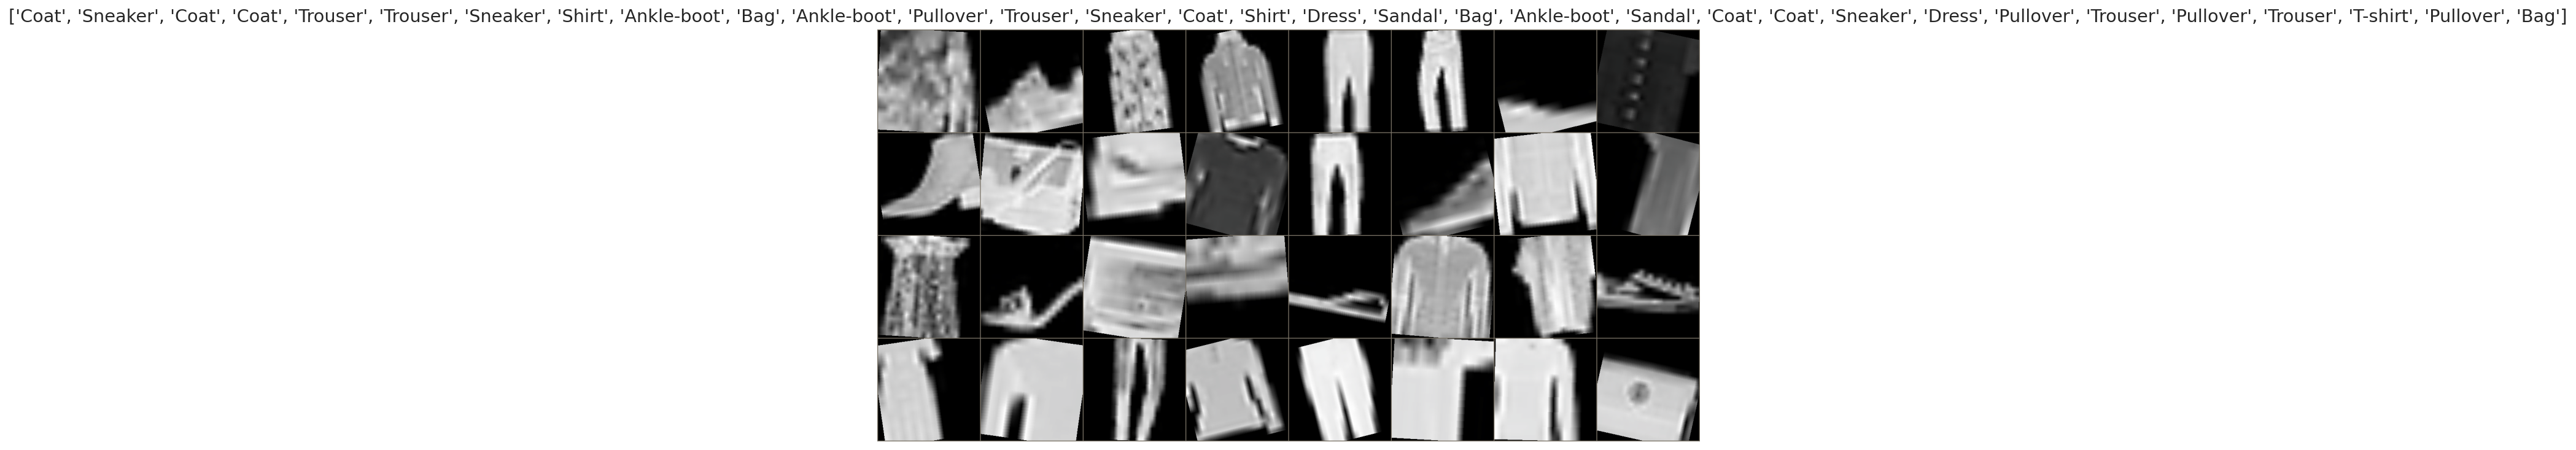

In [28]:
# Grab some of the training data to visualize
inputs, classes = next(iter(data_loaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

**Setting up a Pretrained Model**

In [29]:
# load in pretrained model
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  # reset final fully connected
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  # send our model to the training device - GPU
  return model.to(device)

If this still seems somewhat unclear, visualizing the composition of the model may help.

In [49]:
for name, child in model.named_children():
    print(name)

* Notice the final portion is fc, or "Fully-Connected". This is the only layer we are modifying the shape of, giving it our ten classes to output.

* Essentially, we're going to be changing the outputs of the final fully connected portion to just ten classes, and adjusting the weights for all the other layers.

In [50]:
# Calling the model setup function
base_model = create_model(len(class_names))

**Now we just need to define the functions that will** 
* train the model
* evaluate the model
* get the predictions and
* visualize the predictions.

Every epoch will have a training and validation phase!

Let's start off with the training an epoch function. 

It will take in our chosen model, data_loader, criterion, the choosen optimizer and scheduler, as well as the total number of training samples.

In [30]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):

  # Set model to training mode
  model = model.train()

  losses = []
  correct_predictions = 0
  
  # Here's where the training happens
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    # backward prpogate the gradients
    loss.backward()
    # performs a parameter update based on the current gradient (stored in .grad)
    optimizer.step()
    # for every new batch we need to zero the gradients so as not to accumulate gradients 
    optimizer.zero_grad()

  # learning rate scheduler - decreases learning rate over time
  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

Then comes the evaluation function for each epoch.

It will take in our chosen model, data_loader, criterion as well as the total number of training samples.

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  # Set model to evaluate mode
  model = model.eval()

  losses = []
  correct_predictions = 0

  # Prevents building computational graph and memory usage for the below set of code
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

**Function for training and evaluating the model**

To train the model we need to:

* Choose the loss criterion and optimizer we want to use with the model. 
* We'll also be choosing a learning rate scheduler, which decreases the learning rate of the optimizer overtime and helps prevent non-convergence due to large learning rates.

To begin with, we set the model's initial best weights to those of the pretrained mode, by using state_dict.

Now, for every epoch in the chosen number of epochs, if we are in the training phase, we will:

* Decrement the learning rate
* Zero the gradients
* Carry out the forward training pass
* Calculate the loss
* Do backward propagation and update the weights with the optimizer

In the validation phase we'll be keeping track of the model's accuracy and if the accuracy has improved, we'll save the current weights as the best model weights.


In [32]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):

  # optimizes weights and learning rates to reduce loss
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  # Decay LR by a factor of 0.1 every 7 epochs
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  # loss criterion for multi-class classification
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

**Model training**

In [33]:
# Reloading pre-trained model
base_model = create_model(len(class_names))
base_model.load_state_dict(torch.load('best_model_state.bin'))
base_model = base_model.to(device)

In [54]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.7401730139691259 accuracy 0.734537037037037
Val   loss 0.29604328205769365 accuracy 0.8946666666666666

Epoch 2/3
----------
Train loss 0.5371789655855623 accuracy 0.8062222222222222
Val   loss 0.23693275162355698 accuracy 0.9163333333333333

Epoch 3/3
----------
Train loss 0.49398872429301954 accuracy 0.8205555555555556
Val   loss 0.2483818213197779 accuracy 0.9115

Best val accuracy: 0.9163333333333333
CPU times: user 11min 1s, sys: 6min 25s, total: 17min 27s
Wall time: 19min


**Building test dataset**

In [34]:
image_datasets = {
  'test': ImageFolder(f'{DATA_DIR}/test/', transforms['test'])
  #d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d], loader=gray_reader) for d in DATASETS
}

In [35]:
data_loaders = {
  'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

In [36]:
test_dataset_sizes = len(image_datasets['test'])
test_class_names = image_datasets['test'].classes
print("testdataset sizes are",test_dataset_sizes)
print("available test classes are",test_class_names)

testdataset sizes are 10000
available test classes are ['Unknown']


In [37]:
test_inputs, test_classes = next(iter(data_loaders['test']))
print(test_inputs.shape)

torch.Size([32, 3, 224, 224])


**Visualize Predictions** 

Now we'll create a function that will let us see the predictions our model has made.

In [38]:
def show_predictions(model, class_names, n_images=10):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

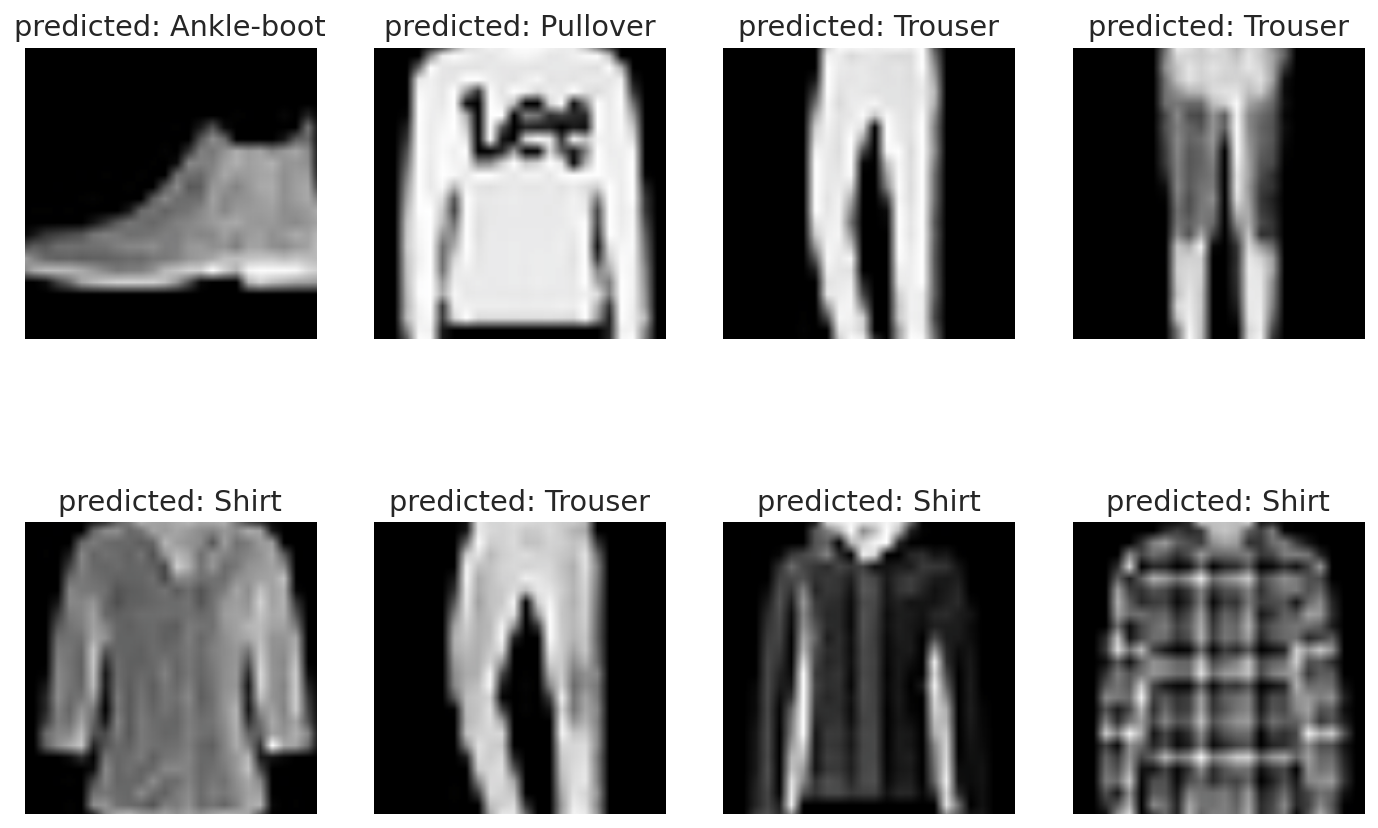

In [40]:
show_predictions(base_model, class_names, n_images=8)

Now that the model is doing a pretty good job in generating test predictions, let's go ahead and take predictions for test data.

**Get test predictions from our model**

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
  predictions = torch.as_tensor(predictions).cpu()
  return predictions

In [42]:
y_pred = get_predictions(base_model, data_loaders['test'])
len(y_pred)

10000

In [43]:
testdata['label']=y_pred
testdata.label.value_counts()

7    1117
3    1073
8    1045
4    1015
1    1013
9     987
6     970
0     947
5     937
2     896
Name: label, dtype: int64

In [44]:
testdata.to_csv('test_predictions.csv',index=False)